In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint


In [72]:
#Load data
data = pd.read_csv('rent_clean.csv')
coords = data[['latitude','longitude']]
coords = coords.dropna()
coords = coords.as_matrix(columns = ['latitude','longitude'])


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (39,50,108) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [73]:
kms_per_radian = 6371.0088
epsilon = 1.5/kms_per_radian
db = DBSCAN(eps = epsilon, min_samples = 1, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(coords))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))


Number of clusters: 3


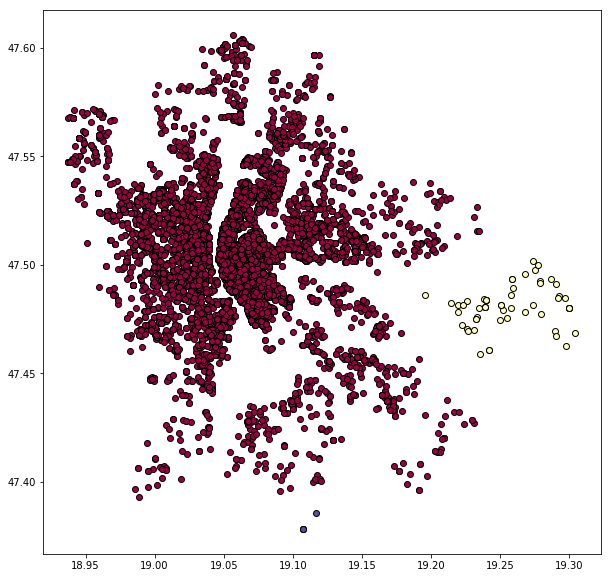

In [83]:
# Black removed and is used for noise instead.
plt.figure(figsize = (10,10))
unique_labels = set(cluster_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (cluster_labels == k)

    xy = coords[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize= 6)

    xy = coords[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize= 6)

#plt.title('Estimated number of clusters:', num_clusters)
plt.show()


In [76]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)


In [77]:
lats, lons = zip(*centermost_points)
rs = pd.DataFrame({'lon':lons, 'lat':lats})


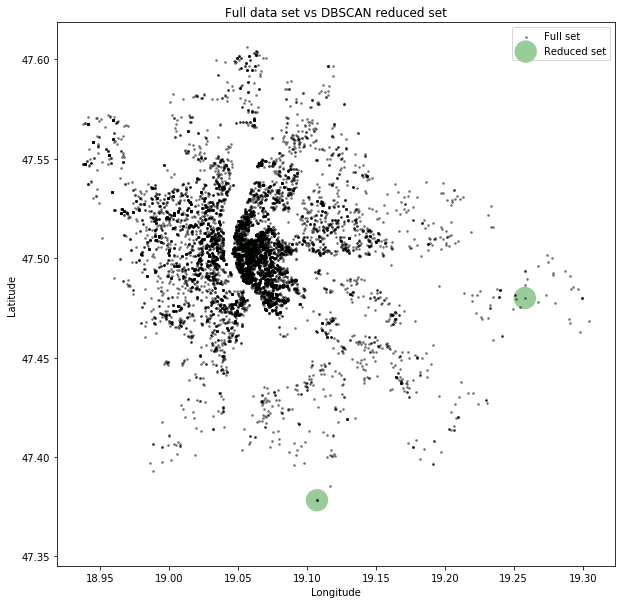

In [78]:
fig, ax = plt.subplots(figsize=[10, 10])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', s=500)
data_scatter = ax.scatter(data['longitude'].dropna(), data['latitude'].dropna(), c='k', alpha=0.4, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([data_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()
